In [1]:
import torch
import os
import random
import datetime
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix

In [2]:
import tqdm

Image 1: US07314871-20080101-C00205.png - Image 2: US07314871-20080101-C00205.png
Image 1: US07314887-20080101-C00073.png - Image 2: US07314887-20080101-C00073.png
Image 1: US07323608-20080129-C00064.png - Image 2: US07323608-20080129-C00064.png
Image 1: US07314883-20080101-C00258.png - Image 2: US07314883-20080101-C00258.png
Image 1: US07323447-20080129-C00278.png - Image 2: US07323447-20080129-C00278.png
Image 1: US07314937-20080101-C00226.png - Image 2: US07314937-20080101-C00226.png
Image 1: US07314934-20080101-C00119.png - Image 2: US07314934-20080101-C00119.png
Image 1: US07314938-20080101-C00208.png - Image 2: US07314938-20080101-C00208.png
Image 1: US07317125-20080108-C00050.png - Image 2: US07317125-20080108-C00050.png
Image 1: US07314937-20080101-C00196.png - Image 2: US07314937-20080101-C00196.png


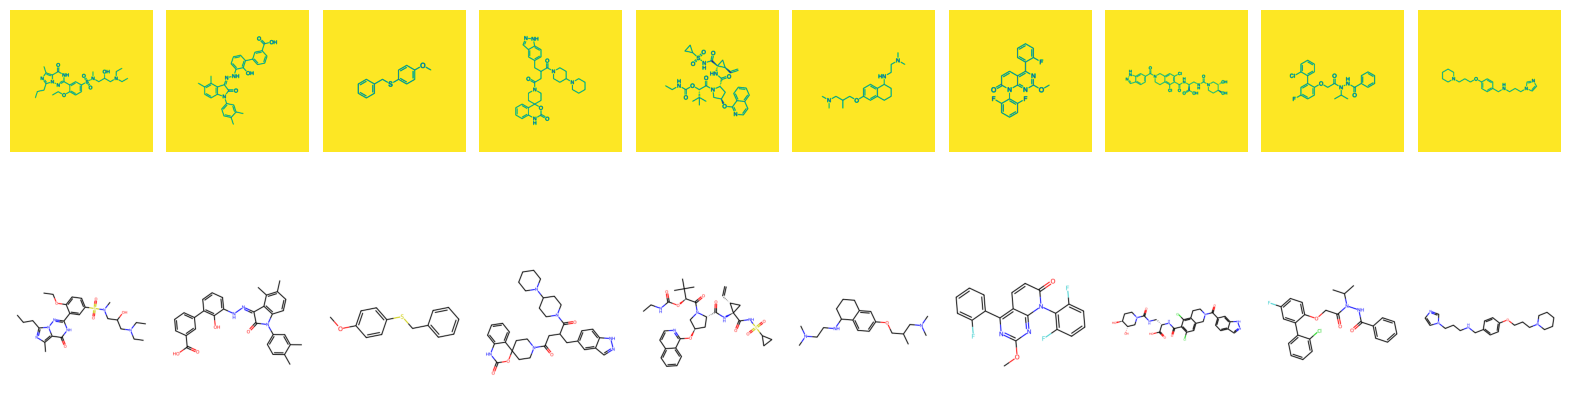

In [3]:
def check_matching_image_counts(root_dir1, root_dir2):
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    return num_images_dir1 == num_images_dir2

def get_matching_indices(root_dir1, root_dir2):
    indices = []
    
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    min_num_images = min(num_images_dir1, num_images_dir2)
    
    for i in range(min_num_images):
        indices.append(i)
        
    return indices

def plot_random_images(root_dir1, root_dir2, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Check if the number of images in each directory matches
    matching_counts = check_matching_image_counts(root_dir1, root_dir2)
    if not matching_counts:
        print("Error: Number of images in each directory does not match.")
        return
    
    # Get matching indices for images from each directory
    indices = get_matching_indices(root_dir1, root_dir2)
    
    # Get random subset of indices
    selected_indices = random.sample(indices, min(num_images, len(indices)))
    
    # Lists to store image names
    img_names1 = []
    img_names2 = []
    
    # Plot images from both directories with the same indices
    for i, idx in enumerate(selected_indices):
        img_name = os.listdir(root_dir1)[idx]
        img_names1.append(img_name)
        img_names2.append(img_name)
        
        img_path_dir1 = os.path.join(root_dir1, img_name)
        img_path_dir2 = os.path.join(root_dir2, img_name)
        
        img_dir1 = Image.open(img_path_dir1)
        img_dir2 = Image.open(img_path_dir2)
        
        axes[0, i].imshow(img_dir1)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img_dir2)
        axes[1, i].axis('off')
    
    # Print paired image names
    for name1, name2 in zip(img_names1, img_names2):
        print(f"Image 1: {name1} - Image 2: {name2}")
    
    plt.show()

# 경로 설정
root_dir1 = 'data/train/chemdraw_train'
root_dir2 = 'data/train/chemdraw_train_smlies'

# 이미지 플로팅
plot_random_images(root_dir1, root_dir2)

In [4]:
class ImagePairDataset(Dataset):
    def __init__(self, root_dir1, root_dir2, label, transform=None):
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.label = label
        self.transform = transform
        self.samples = []
        
        # 두 디렉토리 안의 이미지 파일을 쌍으로 찾기
        for filename in os.listdir(root_dir1):
            img1_path = os.path.join(root_dir1, filename)
            img2_path = os.path.join(root_dir2, filename)
            if os.path.isfile(img1_path) and os.path.isfile(img2_path):
                # 올바른 쌍인 경우 레이블을 설정
                img1 = self.read_image(img1_path)
                img2 = self.read_image(img2_path)
                self.samples.append((img1, img2, self.label))


    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        return self.samples[idx]

    
    def read_image(self, filepath):
        img = Image.open(filepath).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
class CombinedImagePairDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.total_length = len(dataset1) + len(dataset2)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            img1, img2, label = self.dataset1[idx]
            return img1, img2, label
        else:
            # Adjust the index to fit within the second dataset
            adjusted_idx = idx - len(self.dataset1)
            img1, img2, label = self.dataset2[adjusted_idx]
            return img1, img2, label

In [6]:
class ImageComparisonModel(nn.Module):
    def __init__(self):
        super(ImageComparisonModel, self).__init__()
        
        # Stream 1 for the first image modality
        self.stream1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Stream 2 for the second image modality
        self.stream2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fusion and decision mechanism
        self.comparison = nn.Sequential(
            nn.Linear(16*16*256*2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),  # Binary classification
        )
        
    def forward(self, x1, x2):
        x1 = self.stream1(x1)
        x2 = self.stream2(x2)
        
        # Flatten the features from both streams
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate the features
        x = torch.cat((x1, x2), dim=1)
        
        # Pass through the comparison mechanism
        x = self.comparison(x)
        # Apply softmax to get probabilities
        # x = F.softmax(x, dim=1)
        return x

In [7]:
# # 모델 초기화
combined_model = ImageComparisonModel()

print(combined_model)

ImageComparisonModel(
  (stream1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stream2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNo

In [8]:
# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지 크기를 64x64로 조정
    transforms.ToTensor(),         # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

In [9]:
batch_size = 8

In [10]:
# 경로 설정

chemdraw_train = "data/train/chemdraw_train"
chemdraw_test = "data/test/chemdraw_test"
chemdraw_valid = "data/valid/chemdraw_val"

chemdraw_train_smlies = "data/train/chemdraw_train_smlies"
chemdraw_test_smlies = "data/test/chemdraw_test_smlies"
chemdraw_valid_smlies = "data/valid/chemdraw_val_smlies"

chemdraw_train_smlies_wrong = "data/train/chemdraw_train_smlies_wrong"
chemdraw_test_smlies_wrong = "data/test/chemdraw_test_smlies_wrong"
chemdraw_valid_smlies_wrong = "data/valid/chemdraw_val_smlies_wrong"

In [11]:
# 학습 데이터셋 생성
combine_train_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_train, chemdraw_train_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_train, chemdraw_train_smlies_wrong, 0, transform=transform))
combine_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_test, chemdraw_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_test, chemdraw_test_smlies_wrong, 0, transform=transform))
combine_valid_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies_wrong, 0, transform=transform))

# 데이터로더 생성
train_loader = DataLoader(combine_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combine_test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(combine_valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
print(combine_train_dataset.dataset1.root_dir1)
print(combine_train_dataset.dataset1.root_dir2)

print(combine_test_dataset.dataset1.root_dir1)
print(combine_test_dataset.dataset1.root_dir2)

print(combine_valid_dataset.dataset1.root_dir1)
print(combine_valid_dataset.dataset1.root_dir2)

data/train/chemdraw_train
data/train/chemdraw_train_smlies
data/test/chemdraw_test
data/test/chemdraw_test_smlies
data/valid/chemdraw_val
data/valid/chemdraw_val_smlies


In [13]:
# GPU를 사용할 수 있는지 확인합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = combined_model.to(device)

print(device)

cuda


In [45]:
# 학습을 위한 하이퍼파라미터 설정
learning_rate = 1e-5
num_epochs = 200

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(criterion)

BCEWithLogitsLoss()


In [47]:
save_model_path = "Check_Model"

def save_model(model, save_path, acc):
    # 새로운 폴더 생성 (없으면)
    os.makedirs(save_path, exist_ok=True)
    # 현재 시간 가져오기
    now = datetime.datetime.now()
    # 모델 저장
    torch.save(model.state_dict(), os.path.join(save_path, f"model_{now.strftime('%Y%m%d_%H%M%S')}_{acc}.pth"))


def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # 훈련 데이터로 모델 학습
        for inputs1, inputs2, labels in tqdm.tqdm(train_loader, total=len(train_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            # 모델 출력의 크기와 레이블의 크기를 맞추기 위해 labels을 [batch_size, 2]로 변경
            #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            #print(f'[DEBUG] Train Loss: {loss.item():.8f}')
        
        # 평균 훈련 손실 계산
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0
        
        # 검증 데이터로 모델 평가
        with torch.no_grad():
            for inputs1, inputs2, labels in tqdm.tqdm(valid_loader, total=len(valid_loader)):
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                outputs = outputs.squeeze()
                # 모델 출력의 크기와 레이블의 크기를 맞추기 위해 labels을 [batch_size, 2]로 변경
                #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
                loss = criterion(outputs, labels.float())
                running_valid_loss += loss.item()
                
                # 정확도 계산
                #_, predicted = torch.max(outputs, 1)
                #predicted = predicted.unsqueeze(1)  # predicted를 [batch_size, 1]로 변경
                predicted = (outputs > 0).long()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        # 평균 검증 손실 계산
        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        # 정확도 계산
        accuracy = correct / total
        
        # 에포크마다 학습 결과 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.8f}, Valid Loss: {epoch_valid_loss:.8f}, Accuracy: {accuracy:.8f}')
        
        # 20번의 에폭이 끝날 때마다 최고 정확도를 확인하고 모델 저장

        if accuracy > best_accuracy:
            best_accuracy = accuracy

        if (epoch + 1) % 20 == 0:
            if save_path:
                save_model(model, save_path, best_accuracy)
                print("모델이 저장되었습니다.")

        # 모델의 손실이 더 낮아졌을 때 저장
        #if epoch_valid_loss < best_valid_loss:
        #    best_valid_loss = epoch_valid_loss
        #    if save_path:
        #        save_model(model, save_path)

        #print("모델이 저장되었습니다.")
    return train_losses, valid_losses, best_accuracy

In [48]:
# 모델 학습
# num_epochs = 3
train_losses, valid_losses, best_accuracy = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_model_path)

100%|██████████| 130/130 [00:01<00:00, 92.08it/s]


Epoch 1/200, Train Loss: 0.02873299, Valid Loss: 0.29575392, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 92.91it/s]


Epoch 2/200, Train Loss: 0.02477735, Valid Loss: 0.36389900, Accuracy: 0.89038462


100%|██████████| 130/130 [00:01<00:00, 92.86it/s]


Epoch 3/200, Train Loss: 0.03336733, Valid Loss: 0.29621965, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 90.67it/s]


Epoch 4/200, Train Loss: 0.03522577, Valid Loss: 0.25617726, Accuracy: 0.92115385


100%|██████████| 130/130 [00:01<00:00, 90.92it/s]


Epoch 5/200, Train Loss: 0.02290794, Valid Loss: 0.28137390, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 92.44it/s]


Epoch 6/200, Train Loss: 0.03401864, Valid Loss: 0.28236859, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 93.33it/s]


Epoch 7/200, Train Loss: 0.02784447, Valid Loss: 0.29240647, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 93.09it/s]


Epoch 8/200, Train Loss: 0.03584047, Valid Loss: 0.28416247, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 93.08it/s]


Epoch 9/200, Train Loss: 0.02840519, Valid Loss: 0.32151919, Accuracy: 0.89807692


100%|██████████| 130/130 [00:01<00:00, 92.84it/s]


Epoch 10/200, Train Loss: 0.03623098, Valid Loss: 0.29605405, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 93.02it/s]


Epoch 11/200, Train Loss: 0.03062296, Valid Loss: 0.33955872, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 93.21it/s]


Epoch 12/200, Train Loss: 0.03925571, Valid Loss: 0.27567191, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 13/200, Train Loss: 0.03627203, Valid Loss: 0.30368247, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 91.01it/s]


Epoch 14/200, Train Loss: 0.03665447, Valid Loss: 0.31366976, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 93.26it/s]


Epoch 15/200, Train Loss: 0.02851358, Valid Loss: 0.27807304, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 91.12it/s]


Epoch 16/200, Train Loss: 0.03009737, Valid Loss: 0.29894282, Accuracy: 0.90000000


100%|██████████| 130/130 [00:01<00:00, 93.03it/s]


Epoch 17/200, Train Loss: 0.03894249, Valid Loss: 0.34829637, Accuracy: 0.89807692


100%|██████████| 130/130 [00:01<00:00, 91.16it/s]


Epoch 18/200, Train Loss: 0.03619419, Valid Loss: 0.39493768, Accuracy: 0.89038462


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 19/200, Train Loss: 0.03842578, Valid Loss: 0.35021828, Accuracy: 0.89230769


100%|██████████| 130/130 [00:01<00:00, 91.46it/s]


Epoch 20/200, Train Loss: 0.03980990, Valid Loss: 0.26633002, Accuracy: 0.90961538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.96it/s]


Epoch 21/200, Train Loss: 0.02788693, Valid Loss: 0.29386007, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 22/200, Train Loss: 0.04263350, Valid Loss: 0.29726663, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 93.10it/s]


Epoch 23/200, Train Loss: 0.03611299, Valid Loss: 0.31849570, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 92.17it/s]


Epoch 24/200, Train Loss: 0.03636457, Valid Loss: 0.31162442, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 91.98it/s]


Epoch 25/200, Train Loss: 0.02207840, Valid Loss: 0.29444584, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 91.30it/s]


Epoch 26/200, Train Loss: 0.02535230, Valid Loss: 0.37406381, Accuracy: 0.89519231


100%|██████████| 130/130 [00:01<00:00, 93.11it/s]


Epoch 27/200, Train Loss: 0.03608676, Valid Loss: 0.29770230, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 90.70it/s]


Epoch 28/200, Train Loss: 0.02511769, Valid Loss: 0.28691568, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 29/200, Train Loss: 0.02952065, Valid Loss: 0.33470418, Accuracy: 0.89423077


100%|██████████| 130/130 [00:01<00:00, 92.89it/s]


Epoch 30/200, Train Loss: 0.02628215, Valid Loss: 0.37053926, Accuracy: 0.89711538


100%|██████████| 130/130 [00:01<00:00, 93.28it/s]


Epoch 31/200, Train Loss: 0.02848504, Valid Loss: 0.39472244, Accuracy: 0.88846154


100%|██████████| 130/130 [00:01<00:00, 93.03it/s]


Epoch 32/200, Train Loss: 0.02436739, Valid Loss: 0.28717502, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 92.58it/s]


Epoch 33/200, Train Loss: 0.03062343, Valid Loss: 0.29853628, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 91.77it/s]


Epoch 34/200, Train Loss: 0.02890283, Valid Loss: 0.25899035, Accuracy: 0.91923077


100%|██████████| 130/130 [00:01<00:00, 92.42it/s]


Epoch 35/200, Train Loss: 0.03407192, Valid Loss: 0.33851778, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 92.97it/s]


Epoch 36/200, Train Loss: 0.03415523, Valid Loss: 0.32938823, Accuracy: 0.90192308


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 37/200, Train Loss: 0.02969877, Valid Loss: 0.25862902, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 93.37it/s]


Epoch 38/200, Train Loss: 0.03161830, Valid Loss: 0.32538449, Accuracy: 0.90576923


100%|██████████| 130/130 [00:01<00:00, 90.58it/s]


Epoch 39/200, Train Loss: 0.03404523, Valid Loss: 0.29006177, Accuracy: 0.90576923


100%|██████████| 130/130 [00:01<00:00, 91.34it/s]


Epoch 40/200, Train Loss: 0.02766619, Valid Loss: 0.27283837, Accuracy: 0.91057692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.04it/s]


Epoch 41/200, Train Loss: 0.03846245, Valid Loss: 0.30305986, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 93.08it/s]


Epoch 42/200, Train Loss: 0.03543253, Valid Loss: 0.31821579, Accuracy: 0.90096154


100%|██████████| 130/130 [00:01<00:00, 90.58it/s]


Epoch 43/200, Train Loss: 0.03602273, Valid Loss: 0.33563492, Accuracy: 0.90000000


100%|██████████| 130/130 [00:01<00:00, 92.95it/s]


Epoch 44/200, Train Loss: 0.02566296, Valid Loss: 0.32397473, Accuracy: 0.89903846


100%|██████████| 130/130 [00:01<00:00, 93.06it/s]


Epoch 45/200, Train Loss: 0.03631910, Valid Loss: 0.26400201, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 90.68it/s]


Epoch 46/200, Train Loss: 0.03357436, Valid Loss: 0.33475899, Accuracy: 0.89903846


100%|██████████| 130/130 [00:01<00:00, 93.05it/s]


Epoch 47/200, Train Loss: 0.04254565, Valid Loss: 0.34594553, Accuracy: 0.89711538


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 48/200, Train Loss: 0.02654973, Valid Loss: 0.28762622, Accuracy: 0.90384615


100%|██████████| 130/130 [00:01<00:00, 93.02it/s]


Epoch 49/200, Train Loss: 0.03436413, Valid Loss: 0.30895936, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 92.88it/s]


Epoch 50/200, Train Loss: 0.02396779, Valid Loss: 0.26645610, Accuracy: 0.91634615


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 51/200, Train Loss: 0.02799683, Valid Loss: 0.25014963, Accuracy: 0.92788462


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 52/200, Train Loss: 0.02657966, Valid Loss: 0.27486845, Accuracy: 0.91923077


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 53/200, Train Loss: 0.02094349, Valid Loss: 0.30089417, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 93.10it/s]


Epoch 54/200, Train Loss: 0.02689310, Valid Loss: 0.36829457, Accuracy: 0.89711538


100%|██████████| 130/130 [00:01<00:00, 92.87it/s]


Epoch 55/200, Train Loss: 0.04436447, Valid Loss: 0.35776501, Accuracy: 0.89615385


100%|██████████| 130/130 [00:01<00:00, 90.59it/s]


Epoch 56/200, Train Loss: 0.03764424, Valid Loss: 0.28560087, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 93.30it/s]


Epoch 57/200, Train Loss: 0.02335397, Valid Loss: 0.29438578, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 92.96it/s]


Epoch 58/200, Train Loss: 0.02759183, Valid Loss: 0.38061541, Accuracy: 0.89134615


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 59/200, Train Loss: 0.03185313, Valid Loss: 0.31363633, Accuracy: 0.90192308


100%|██████████| 130/130 [00:01<00:00, 91.53it/s]


Epoch 60/200, Train Loss: 0.03127510, Valid Loss: 0.27782545, Accuracy: 0.91250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.74it/s]


Epoch 61/200, Train Loss: 0.02402197, Valid Loss: 0.28520430, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 62/200, Train Loss: 0.02836355, Valid Loss: 0.26817931, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 93.14it/s]


Epoch 63/200, Train Loss: 0.01942522, Valid Loss: 0.31433346, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 92.18it/s]


Epoch 64/200, Train Loss: 0.03082930, Valid Loss: 0.31299112, Accuracy: 0.90096154


100%|██████████| 130/130 [00:01<00:00, 93.23it/s]


Epoch 65/200, Train Loss: 0.02666622, Valid Loss: 0.28562227, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 93.16it/s]


Epoch 66/200, Train Loss: 0.02983226, Valid Loss: 0.28843624, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 91.90it/s]


Epoch 67/200, Train Loss: 0.03032932, Valid Loss: 0.31811514, Accuracy: 0.90192308


100%|██████████| 130/130 [00:01<00:00, 91.42it/s]


Epoch 68/200, Train Loss: 0.03461573, Valid Loss: 0.26209856, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 92.86it/s]


Epoch 69/200, Train Loss: 0.03417209, Valid Loss: 0.28153682, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 92.02it/s]


Epoch 70/200, Train Loss: 0.03273538, Valid Loss: 0.27541992, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 71/200, Train Loss: 0.03218136, Valid Loss: 0.27429215, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 92.00it/s]


Epoch 72/200, Train Loss: 0.03203061, Valid Loss: 0.27230278, Accuracy: 0.91923077


100%|██████████| 130/130 [00:01<00:00, 91.30it/s]


Epoch 73/200, Train Loss: 0.03219983, Valid Loss: 0.26415386, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 93.16it/s]


Epoch 74/200, Train Loss: 0.02868910, Valid Loss: 0.31579082, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 92.84it/s]


Epoch 75/200, Train Loss: 0.02704650, Valid Loss: 0.26757405, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 92.75it/s]


Epoch 76/200, Train Loss: 0.02404632, Valid Loss: 0.35398233, Accuracy: 0.89519231


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 77/200, Train Loss: 0.03273351, Valid Loss: 0.28730910, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 93.21it/s]


Epoch 78/200, Train Loss: 0.02906442, Valid Loss: 0.28153008, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 91.84it/s]


Epoch 79/200, Train Loss: 0.02061097, Valid Loss: 0.27788281, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 92.99it/s]


Epoch 80/200, Train Loss: 0.02640013, Valid Loss: 0.27650447, Accuracy: 0.91346154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.97it/s]


Epoch 81/200, Train Loss: 0.02744640, Valid Loss: 0.34608132, Accuracy: 0.88750000


100%|██████████| 130/130 [00:01<00:00, 92.73it/s]


Epoch 82/200, Train Loss: 0.03303223, Valid Loss: 0.30805578, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 93.10it/s]


Epoch 83/200, Train Loss: 0.03546235, Valid Loss: 0.29460762, Accuracy: 0.92115385


100%|██████████| 130/130 [00:01<00:00, 93.17it/s]


Epoch 84/200, Train Loss: 0.03020804, Valid Loss: 0.32590426, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 93.21it/s]


Epoch 85/200, Train Loss: 0.03008175, Valid Loss: 0.36030566, Accuracy: 0.89423077


100%|██████████| 130/130 [00:01<00:00, 90.94it/s]


Epoch 86/200, Train Loss: 0.03700143, Valid Loss: 0.26320179, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 92.96it/s]


Epoch 87/200, Train Loss: 0.03823617, Valid Loss: 0.31115123, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 93.04it/s]


Epoch 88/200, Train Loss: 0.02998235, Valid Loss: 0.32778650, Accuracy: 0.89711538


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 89/200, Train Loss: 0.01673562, Valid Loss: 0.28992625, Accuracy: 0.90576923


100%|██████████| 130/130 [00:01<00:00, 93.13it/s]


Epoch 90/200, Train Loss: 0.03275634, Valid Loss: 0.32032036, Accuracy: 0.89903846


100%|██████████| 130/130 [00:01<00:00, 93.11it/s]


Epoch 91/200, Train Loss: 0.02431321, Valid Loss: 0.25336544, Accuracy: 0.91923077


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 92/200, Train Loss: 0.02810380, Valid Loss: 0.27762261, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 93.28it/s]


Epoch 93/200, Train Loss: 0.03602747, Valid Loss: 0.37231771, Accuracy: 0.88846154


100%|██████████| 130/130 [00:01<00:00, 93.14it/s]


Epoch 94/200, Train Loss: 0.03237071, Valid Loss: 0.35212381, Accuracy: 0.89903846


100%|██████████| 130/130 [00:01<00:00, 93.22it/s]


Epoch 95/200, Train Loss: 0.03126239, Valid Loss: 0.32369121, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 93.05it/s]


Epoch 96/200, Train Loss: 0.02981557, Valid Loss: 0.27872395, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 92.98it/s]


Epoch 97/200, Train Loss: 0.03235051, Valid Loss: 0.30633741, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 92.91it/s]


Epoch 98/200, Train Loss: 0.02182475, Valid Loss: 0.40409256, Accuracy: 0.88942308


100%|██████████| 130/130 [00:01<00:00, 92.95it/s]


Epoch 99/200, Train Loss: 0.02671506, Valid Loss: 0.28448477, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 93.33it/s]


Epoch 100/200, Train Loss: 0.03696288, Valid Loss: 0.31280030, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.27it/s]


Epoch 101/200, Train Loss: 0.02836072, Valid Loss: 0.27506904, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 93.30it/s]


Epoch 102/200, Train Loss: 0.02458343, Valid Loss: 0.26437461, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 89.86it/s]


Epoch 103/200, Train Loss: 0.02990433, Valid Loss: 0.35138936, Accuracy: 0.89711538


100%|██████████| 130/130 [00:01<00:00, 92.92it/s]


Epoch 104/200, Train Loss: 0.02595521, Valid Loss: 0.27970588, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 92.86it/s]


Epoch 105/200, Train Loss: 0.02421565, Valid Loss: 0.34433729, Accuracy: 0.90000000


100%|██████████| 130/130 [00:01<00:00, 93.29it/s]


Epoch 106/200, Train Loss: 0.03496293, Valid Loss: 0.25061862, Accuracy: 0.92019231


100%|██████████| 130/130 [00:01<00:00, 93.17it/s]


Epoch 107/200, Train Loss: 0.02464155, Valid Loss: 0.29909399, Accuracy: 0.90096154


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 108/200, Train Loss: 0.02217062, Valid Loss: 0.28954519, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 91.10it/s]


Epoch 109/200, Train Loss: 0.02531425, Valid Loss: 0.36541192, Accuracy: 0.89038462


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 110/200, Train Loss: 0.02799615, Valid Loss: 0.28454483, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 93.24it/s]


Epoch 111/200, Train Loss: 0.02715700, Valid Loss: 0.27494693, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 93.38it/s]


Epoch 112/200, Train Loss: 0.02270632, Valid Loss: 0.29189605, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 91.17it/s]


Epoch 113/200, Train Loss: 0.02357201, Valid Loss: 0.29299253, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 93.30it/s]


Epoch 114/200, Train Loss: 0.02793961, Valid Loss: 0.26811828, Accuracy: 0.91923077


100%|██████████| 130/130 [00:01<00:00, 92.86it/s]


Epoch 115/200, Train Loss: 0.03191706, Valid Loss: 0.32412985, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 92.92it/s]


Epoch 116/200, Train Loss: 0.02395752, Valid Loss: 0.31277691, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 92.00it/s]


Epoch 117/200, Train Loss: 0.03738831, Valid Loss: 0.32219918, Accuracy: 0.90576923


100%|██████████| 130/130 [00:01<00:00, 90.72it/s]


Epoch 118/200, Train Loss: 0.02755788, Valid Loss: 0.24803953, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 93.34it/s]


Epoch 119/200, Train Loss: 0.02488264, Valid Loss: 0.32944942, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 93.21it/s]


Epoch 120/200, Train Loss: 0.02826598, Valid Loss: 0.32188986, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 121/200, Train Loss: 0.03017663, Valid Loss: 0.26203956, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 93.32it/s]


Epoch 122/200, Train Loss: 0.02328525, Valid Loss: 0.31607326, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 91.69it/s]


Epoch 123/200, Train Loss: 0.02728169, Valid Loss: 0.28496359, Accuracy: 0.92211538


100%|██████████| 130/130 [00:01<00:00, 90.30it/s]


Epoch 124/200, Train Loss: 0.02191691, Valid Loss: 0.37312898, Accuracy: 0.90000000


100%|██████████| 130/130 [00:01<00:00, 93.06it/s]


Epoch 125/200, Train Loss: 0.03168437, Valid Loss: 0.33488857, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 93.32it/s]


Epoch 126/200, Train Loss: 0.02796979, Valid Loss: 0.28324680, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 92.99it/s]


Epoch 127/200, Train Loss: 0.02061506, Valid Loss: 0.32257236, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 93.08it/s]


Epoch 128/200, Train Loss: 0.02527803, Valid Loss: 0.32068484, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 93.34it/s]


Epoch 129/200, Train Loss: 0.02699864, Valid Loss: 0.28128434, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 91.19it/s]


Epoch 130/200, Train Loss: 0.02943219, Valid Loss: 0.34716298, Accuracy: 0.90384615


100%|██████████| 130/130 [00:01<00:00, 93.03it/s]


Epoch 131/200, Train Loss: 0.03138376, Valid Loss: 0.28490155, Accuracy: 0.91634615


100%|██████████| 130/130 [00:01<00:00, 90.45it/s]


Epoch 132/200, Train Loss: 0.02698349, Valid Loss: 0.30539763, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 91.20it/s]


Epoch 133/200, Train Loss: 0.01905781, Valid Loss: 0.33130994, Accuracy: 0.89903846


100%|██████████| 130/130 [00:01<00:00, 91.11it/s]


Epoch 134/200, Train Loss: 0.01812097, Valid Loss: 0.31630348, Accuracy: 0.90384615


100%|██████████| 130/130 [00:01<00:00, 92.99it/s]


Epoch 135/200, Train Loss: 0.02234515, Valid Loss: 0.28022402, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 92.82it/s]


Epoch 136/200, Train Loss: 0.02381153, Valid Loss: 0.29890248, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 93.09it/s]


Epoch 137/200, Train Loss: 0.01998366, Valid Loss: 0.38187567, Accuracy: 0.89615385


100%|██████████| 130/130 [00:01<00:00, 92.07it/s]


Epoch 138/200, Train Loss: 0.03023699, Valid Loss: 0.31040251, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 90.59it/s]


Epoch 139/200, Train Loss: 0.02863579, Valid Loss: 0.27987016, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 91.24it/s]


Epoch 140/200, Train Loss: 0.03102289, Valid Loss: 0.35989649, Accuracy: 0.91153846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.07it/s]


Epoch 141/200, Train Loss: 0.02221083, Valid Loss: 0.33246719, Accuracy: 0.90000000


100%|██████████| 130/130 [00:01<00:00, 92.23it/s]


Epoch 142/200, Train Loss: 0.02328708, Valid Loss: 0.36428695, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 92.94it/s]


Epoch 143/200, Train Loss: 0.02565377, Valid Loss: 0.27676484, Accuracy: 0.91634615


100%|██████████| 130/130 [00:01<00:00, 91.02it/s]


Epoch 144/200, Train Loss: 0.02911470, Valid Loss: 0.29204772, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 90.75it/s]


Epoch 145/200, Train Loss: 0.02664877, Valid Loss: 0.34174965, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 90.95it/s]


Epoch 146/200, Train Loss: 0.02263299, Valid Loss: 0.30031619, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 90.78it/s]


Epoch 147/200, Train Loss: 0.01553844, Valid Loss: 0.28308564, Accuracy: 0.90769231


100%|██████████| 130/130 [00:01<00:00, 93.19it/s]


Epoch 148/200, Train Loss: 0.02943625, Valid Loss: 0.29587808, Accuracy: 0.92115385


100%|██████████| 130/130 [00:01<00:00, 93.07it/s]


Epoch 149/200, Train Loss: 0.01876560, Valid Loss: 0.31275751, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 150/200, Train Loss: 0.02544772, Valid Loss: 0.28213004, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 91.56it/s]


Epoch 151/200, Train Loss: 0.02412024, Valid Loss: 0.33720776, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 93.21it/s]


Epoch 152/200, Train Loss: 0.02703789, Valid Loss: 0.30712643, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 92.76it/s]


Epoch 153/200, Train Loss: 0.02099368, Valid Loss: 0.34000220, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 91.35it/s]


Epoch 154/200, Train Loss: 0.02455047, Valid Loss: 0.26974039, Accuracy: 0.91634615


100%|██████████| 130/130 [00:01<00:00, 92.96it/s]


Epoch 155/200, Train Loss: 0.02473126, Valid Loss: 0.38867534, Accuracy: 0.90000000


100%|██████████| 130/130 [00:01<00:00, 91.66it/s]


Epoch 156/200, Train Loss: 0.02159868, Valid Loss: 0.31805456, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 90.68it/s]


Epoch 157/200, Train Loss: 0.02686258, Valid Loss: 0.31756428, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 158/200, Train Loss: 0.01825185, Valid Loss: 0.27472168, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 93.21it/s]


Epoch 159/200, Train Loss: 0.02773623, Valid Loss: 0.25261078, Accuracy: 0.92019231


100%|██████████| 130/130 [00:01<00:00, 93.22it/s]


Epoch 160/200, Train Loss: 0.02473259, Valid Loss: 0.31563993, Accuracy: 0.91634615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.97it/s]


Epoch 161/200, Train Loss: 0.02601274, Valid Loss: 0.28311863, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 90.37it/s]


Epoch 162/200, Train Loss: 0.02725189, Valid Loss: 0.23512809, Accuracy: 0.92307692


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 163/200, Train Loss: 0.01951128, Valid Loss: 0.29782153, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 92.93it/s]


Epoch 164/200, Train Loss: 0.02130419, Valid Loss: 0.27947917, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 92.18it/s]


Epoch 165/200, Train Loss: 0.02225516, Valid Loss: 0.30867723, Accuracy: 0.90865385


100%|██████████| 130/130 [00:01<00:00, 91.90it/s]


Epoch 166/200, Train Loss: 0.02085975, Valid Loss: 0.28734967, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 167/200, Train Loss: 0.02449148, Valid Loss: 0.26332883, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 168/200, Train Loss: 0.02451688, Valid Loss: 0.27464184, Accuracy: 0.91057692


100%|██████████| 130/130 [00:01<00:00, 93.37it/s]


Epoch 169/200, Train Loss: 0.02125206, Valid Loss: 0.32087475, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 91.85it/s]


Epoch 170/200, Train Loss: 0.02671002, Valid Loss: 0.31376737, Accuracy: 0.90192308


100%|██████████| 130/130 [00:01<00:00, 91.41it/s]


Epoch 171/200, Train Loss: 0.02042037, Valid Loss: 0.33300682, Accuracy: 0.90480769


100%|██████████| 130/130 [00:01<00:00, 92.90it/s]


Epoch 172/200, Train Loss: 0.02254945, Valid Loss: 0.25012420, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 93.08it/s]


Epoch 173/200, Train Loss: 0.02476160, Valid Loss: 0.31169873, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 93.23it/s]


Epoch 174/200, Train Loss: 0.01766851, Valid Loss: 0.30233517, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 93.20it/s]


Epoch 175/200, Train Loss: 0.02366221, Valid Loss: 0.30198183, Accuracy: 0.90961538


100%|██████████| 130/130 [00:01<00:00, 90.61it/s]


Epoch 176/200, Train Loss: 0.02143016, Valid Loss: 0.23401019, Accuracy: 0.92019231


100%|██████████| 130/130 [00:01<00:00, 92.12it/s]


Epoch 177/200, Train Loss: 0.02500387, Valid Loss: 0.29866248, Accuracy: 0.91538462


100%|██████████| 130/130 [00:01<00:00, 92.62it/s]


Epoch 178/200, Train Loss: 0.02656367, Valid Loss: 0.32419004, Accuracy: 0.90673077


100%|██████████| 130/130 [00:01<00:00, 92.86it/s]


Epoch 179/200, Train Loss: 0.02689589, Valid Loss: 0.26286798, Accuracy: 0.92115385


100%|██████████| 130/130 [00:01<00:00, 91.78it/s]


Epoch 180/200, Train Loss: 0.02211510, Valid Loss: 0.30596642, Accuracy: 0.91346154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.78it/s]


Epoch 181/200, Train Loss: 0.02373915, Valid Loss: 0.35423419, Accuracy: 0.90576923


100%|██████████| 130/130 [00:01<00:00, 91.84it/s]


Epoch 182/200, Train Loss: 0.02103205, Valid Loss: 0.26931527, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 93.30it/s]


Epoch 183/200, Train Loss: 0.02037373, Valid Loss: 0.29581819, Accuracy: 0.91153846


100%|██████████| 130/130 [00:01<00:00, 93.09it/s]


Epoch 184/200, Train Loss: 0.02275299, Valid Loss: 0.28859225, Accuracy: 0.91346154


100%|██████████| 130/130 [00:01<00:00, 92.98it/s]


Epoch 185/200, Train Loss: 0.02682230, Valid Loss: 0.26429401, Accuracy: 0.92500000


100%|██████████| 130/130 [00:01<00:00, 91.52it/s]


Epoch 186/200, Train Loss: 0.02405876, Valid Loss: 0.31535563, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 90.66it/s]


Epoch 187/200, Train Loss: 0.03058977, Valid Loss: 0.39100133, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 92.94it/s]


Epoch 188/200, Train Loss: 0.02161192, Valid Loss: 0.36104725, Accuracy: 0.90384615


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 189/200, Train Loss: 0.02495304, Valid Loss: 0.29995644, Accuracy: 0.91730769


100%|██████████| 130/130 [00:01<00:00, 93.09it/s]


Epoch 190/200, Train Loss: 0.01497224, Valid Loss: 0.30522551, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 92.72it/s]


Epoch 191/200, Train Loss: 0.02772335, Valid Loss: 0.31734254, Accuracy: 0.91250000


100%|██████████| 130/130 [00:01<00:00, 93.28it/s]


Epoch 192/200, Train Loss: 0.02832305, Valid Loss: 0.35601869, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 193/200, Train Loss: 0.02700649, Valid Loss: 0.27217229, Accuracy: 0.92211538


100%|██████████| 130/130 [00:01<00:00, 93.23it/s]


Epoch 194/200, Train Loss: 0.02670430, Valid Loss: 0.35175972, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 195/200, Train Loss: 0.02745036, Valid Loss: 0.27738052, Accuracy: 0.92211538


100%|██████████| 130/130 [00:01<00:00, 91.06it/s]


Epoch 196/200, Train Loss: 0.03086742, Valid Loss: 0.36530494, Accuracy: 0.90288462


100%|██████████| 130/130 [00:01<00:00, 90.81it/s]


Epoch 197/200, Train Loss: 0.03087423, Valid Loss: 0.26876418, Accuracy: 0.91442308


100%|██████████| 130/130 [00:01<00:00, 92.81it/s]


Epoch 198/200, Train Loss: 0.02234401, Valid Loss: 0.33938376, Accuracy: 0.90384615


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 199/200, Train Loss: 0.01686756, Valid Loss: 0.29349507, Accuracy: 0.91826923


100%|██████████| 130/130 [00:01<00:00, 91.14it/s]


Epoch 200/200, Train Loss: 0.02951809, Valid Loss: 0.28278420, Accuracy: 0.91730769
모델이 저장되었습니다.


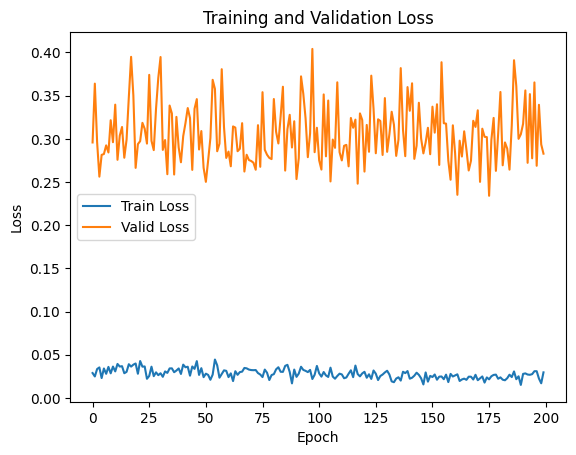

In [49]:
# 학습 결과 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
print(train_losses, valid_losses, best_accuracy)

[0.028732986755847508, 0.024777351522117415, 0.03336732968289056, 0.035225766468202774, 0.022907939807508798, 0.03401864013628488, 0.027844467016515086, 0.03584047103005244, 0.02840519427178984, 0.03623097627003279, 0.03062296105551551, 0.03925570676820894, 0.03627202533290013, 0.03665447275724996, 0.02851358423287838, 0.030097372471914616, 0.038942489185144064, 0.03619418635135813, 0.03842578341383957, 0.039809897632793544, 0.027886929616327452, 0.04263350484255317, 0.03611299002528524, 0.036364565984244764, 0.022078396904864475, 0.02535230102276677, 0.03608675680498201, 0.025117686472795588, 0.029520649499613607, 0.02628214549970722, 0.02848503501523791, 0.02436738594290243, 0.03062342924564135, 0.02890282820801723, 0.03407191601687297, 0.03415522751180888, 0.029698773431414062, 0.031618300278294875, 0.03404523422450219, 0.027666187023937715, 0.038462447187695634, 0.03543252501096582, 0.03602273204138592, 0.02566295549857229, 0.03631909678437881, 0.03357436089174189, 0.04254564833394

In [51]:
chemdraw_final_test = "data_test/chemdraw_LastTestSet"
chemdraw_final_test_smlies = "data_test/chemdraw_LastTestSet_smlies"
chemdraw_final_test_smlies_wrong = "data_test/chemdraw_LastTestSet_smlies_wrong"

In [52]:
combine_final_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_final_test, chemdraw_final_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_final_test, chemdraw_final_test_smlies_wrong, 0, transform=transform))

In [53]:
combine_final_test_loader = DataLoader(combine_final_test_dataset, batch_size=batch_size, shuffle=False)

In [65]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs1, inputs2, labels in tqdm.tqdm(test_loader, total=len(test_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            # 이진 분류 문제이므로 0.5를 기준으로 양성(1) 또는 음성(0)으로 분류합니다.
            predicted = (outputs > 0.5).long()
            predictions.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    return predictions, true_labels

In [66]:
# 모델 평가
predictions, true_labels = evaluate_model(model, test_loader)
predictions_test, true_labels_test = evaluate_model(model, combine_final_test_loader)

# 오차 행렬 계산
conf_matrix = confusion_matrix(true_labels, predictions)
conf_matrix_test = confusion_matrix(true_labels_test, predictions_test)

print("Confusion Matrix:")
print(conf_matrix)
print("Confusion Matrix Test:")
print(conf_matrix_test)

100%|██████████| 63/63 [00:00<00:00, 92.30it/s]

Confusion Matrix:
[[ 923  119]
 [  40 1002]]
Confusion Matrix Test:
[[  0   0]
 [117 383]]


In [67]:
def calculate_precision_recall(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]
    true_negatives = conf_matrix[0, 0]
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return precision, recall, true_positives, false_positives, false_negatives, true_negatives

In [71]:
# 오차 행렬로부터 재현율과 정밀도, 그리고 TP, FP, FN, TN 계산
precision, recall, tp, fp, fn, tn = calculate_precision_recall(conf_matrix)
precision_test, recall_test, tp_test, fp_test, fn_test, tn_test = calculate_precision_recall(conf_matrix_test)

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Negatives:", tn)
print("\n")
print("True Positives Test:", tp_test)
print("False Positives Test:", fp_test)
print("False Negatives Test:", fn_test)
print("True Negatives Test:", tn_test)

True Positives: 1002
False Positives: 119
False Negatives: 40
True Negatives: 923


True Positives Test: 383
False Positives Test: 0
False Negatives Test: 117
True Negatives Test: 0


In [72]:
print("Precision:", precision)
print("Recall:", recall)
print("\n")
print("Precision Test:", precision_test)
print("Recall Test:", recall_test)

Precision: 0.8938447814451382
Recall: 0.9616122840690979


Precision Test: 1.0
Recall Test: 0.766


In [73]:
def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

In [75]:
# 정밀도, 재현율로부터 F1-score 계산
f1_score = calculate_f1_score(precision, recall)
f1_score_test = calculate_f1_score(precision_test, recall_test)

print("F1-score:", f1_score)
print("\n")
print("F1-score Test:", f1_score_test)

F1-score: 0.9264909847434118


F1-score Test: 0.8674971687429218
